In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim


# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# from torchvision.datasets import CocoDetection

# RTML Midterm 2021 - st121413

1. In Lab 06, you fine tuned a Mask R-CNN model on the Cityscapes dataset. Download the image at http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg and run it through
   you model. Provide your source code to load the model, image, get the result, and display the result here. Display the resulting bounding boxes and masks. 

In [2]:
# Code to load model, image, and display result here
# Load Model
print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
model.load_state_dict(torch.load('../lab6/checkpoints/maskrcnn-99.pth'))
model.eval()

Loading pretrained model...


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

torch.Size([1, 3, 3024, 4032])


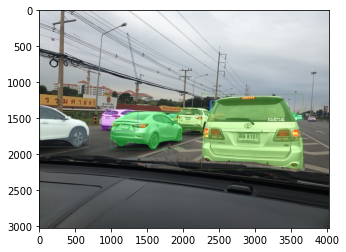

In [3]:
# Load Image
# !wget http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg 

# Load Things to device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# print(device)
model.to(device)

image = Image.open('20201112_072342.jpg')
preprocess = transforms.Compose([
    transforms.RandomVerticalFlip(1),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
])

x = preprocess(image).unsqueeze(0)
print(x.shape)
x = x.to(device)
prediction = model(x)

# Display Result
from mask_util import prediction_to_mask_image
masked_img = prediction_to_mask_image(x, prediction, 0, 0.5)
plt.imshow(masked_img)

2. Write a program that samples 1000 points from a mixture of 4 2D Gaussians with identity covariance centered at (5,5), (10,5), (5,10), and (10,10).

   Provide the code and a plot of the sample.

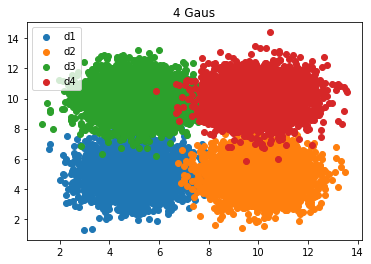

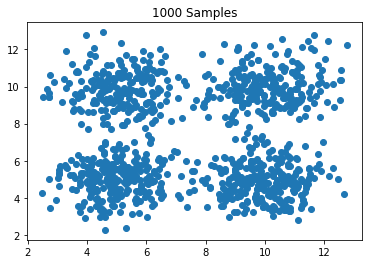

In [4]:
# Code to sample data and display plot here
def gaus(center, size):
    c_x, c_y = center
    X = torch.randn(size) + c_x
    Y = torch.randn(size) + c_y
    X = torch.reshape(X, (1,-1))
    Y = torch.reshape(Y, (1,-1))
    data = torch.cat([X, Y], 0 ).T
    # print(data)
    return data

def mGaus(plot=False):
    c1 = (5,5)
    d1 = gaus(c1, 4000)
    c2 = (10,5)
    d2 = gaus(c2, 4000)
    c3 = (5,10)
    d3 = gaus(c3, 4000)
    c4 = (10,10)
    d4 = gaus(c4, 4000)
    if plot:
        plt.scatter(d1.numpy()[:,0], d1.numpy()[:,1], label='d1')
        plt.scatter(d2.numpy()[:,0], d2.numpy()[:,1], label='d2')
        plt.scatter(d3.numpy()[:,0], d3.numpy()[:,1], label='d3')
        plt.scatter(d4.numpy()[:,0], d4.numpy()[:,1], label='d4')
        plt.title('4 Gaus')
        plt.legend()
        plt.show()
    data = torch.cat( [d1,d2,d3,d4] )
    return data

def getData(size = 1000, plot=False):
    data = mGaus(plot=plot)
    index =  np.arange(0, data.shape[0])
    np.random.shuffle(index)
    # print(index[:size])
    # print(data[index[:size]])
    return data[index[:size]]

data = getData(1000,plot=True)
plt.scatter(data[:,0], data[:,1])
plt.title('1000 Samples')
plt.show()


In [5]:
import torch
class MyData(torch.utils.data.Dataset):
    def __init__(self, size = 1000):
        self.data = getData(size)
        self.size = size

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.size
        
mydata = MyData()
mydata.__len__()
mydata.__getitem__(0)

tensor([4.8560, 8.2824])

3. Write a GAN generator G and discriminator D to model the dataset you generated in Question 2. Train the GAN and display two plots: a fake sample from the generator and the original sample from Question 2.

In [6]:
# Copy from Snake GAN
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            # nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Function to create noise samples for the generator's input

def noise(batchSize):
    n = torch.randn(batchSize, 2)
    if torch.cuda.is_available(): return n.cuda() 
    return n

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [8]:
# Code for the GAN and plots here
data_loader = torch.utils.data.DataLoader(mydata, batch_size=100, shuffle=True)
num_batches = len(data_loader)
print(num_batches)

10


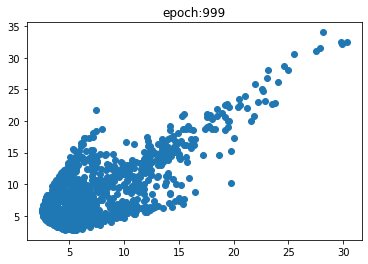

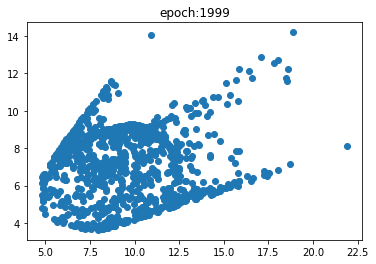

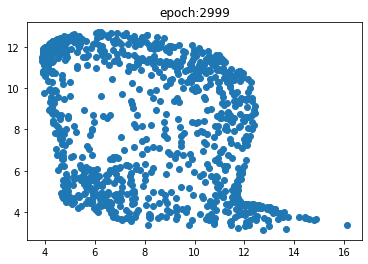

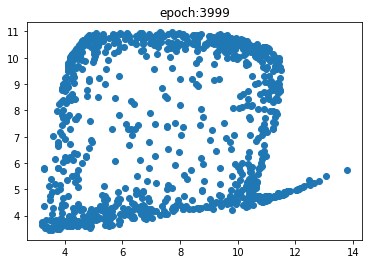

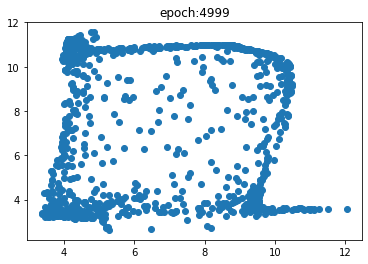

In [12]:
# discriminator = DiscriminatorNet()
# generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 5000

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

num_test_samples = 1000
test_noise = noise(num_test_samples)
d_error_list = list()
g_error_list = list()
for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        # print(real_batch.shape)
        real_data = real_batch#images_to_vectors(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress
        # logger.log(d_error, g_error, epoch, n_batch, num_batches)
        d_error_list.append(d_error)
        g_error_list.append(g_error)
        if (n_batch) % 1000 == 0 and (epoch+1) % 1000 == 0:
            # Display Images
            test_images = generator(test_noise)
            test_images = test_images.detach().cpu()
            plt.scatter(test_images[:,0], test_images[:,1])
            plt.title(f'epoch:{epoch}')
            plt.show()
 

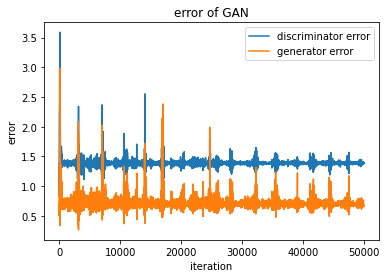

In [26]:
# print(d_error_list[:10])

plt.plot(d_error_list, label='discriminator error')
plt.plot(g_error_list, label='generator error')
plt.title("error of GAN")
plt.ylabel('error')
plt.xlabel('iteration')
plt.legend()
plt.show()

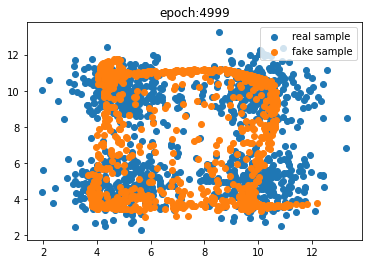

In [29]:
real_samples = mydata.data 
plt.scatter(real_samples[:,0], real_samples[:,1], label='real sample')

test_noise = noise(1000)
test_samples = generator(test_noise)
test_samples = test_samples.detach().cpu()
plt.scatter(test_samples[:,0], test_samples[:,1], label='fake sample')

plt.title(f'epoch:{epoch}')
plt.legend()
plt.show()

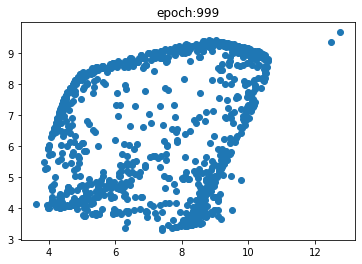

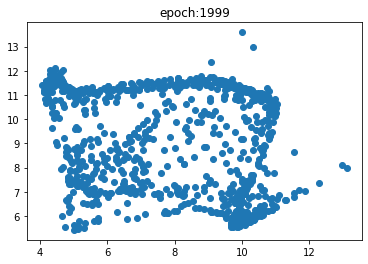

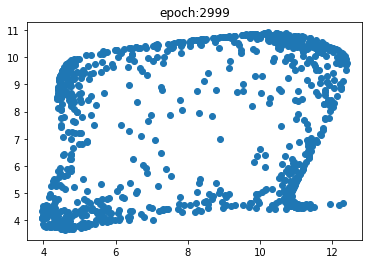

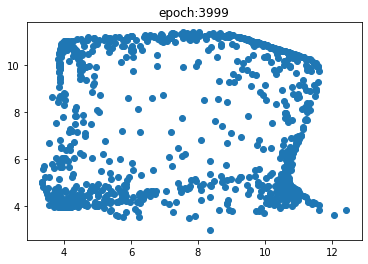

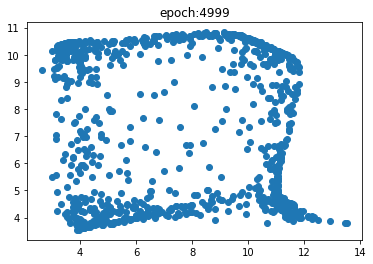

In [32]:
# Continue to train GAN here because I have little time left


num_test_samples = 1000
test_noise = noise(num_test_samples)
d_error_list = list()
g_error_list = list()
for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        real_data = real_batch
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress
        d_error_list.append(d_error)
        g_error_list.append(g_error)
        if (n_batch) % 1000 == 0 and (epoch+1) % 1000 == 0:
            # Display Images
            test_images = generator(test_noise)
            test_images = test_images.detach().cpu()
            plt.scatter(test_images[:,0], test_images[:,1])
            plt.title(f'epoch:{epoch}')
            plt.show()

In [ ]:
# Continue 2 to train GAN here because I have little time left


num_test_samples = 1000
test_noise = noise(num_test_samples)
d_error_list = list()
g_error_list = list()
for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        real_data = real_batch
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress
        d_error_list.append(d_error)
        g_error_list.append(g_error)
        if (n_batch) % 1000 == 0 and (epoch+1) % 1000 == 0:
            # Display Images
            test_images = generator(test_noise)
            test_images = test_images.detach().cpu()
            plt.scatter(test_images[:,0], test_images[:,1])
            plt.title(f'epoch:{epoch}')
            plt.show()

4. Suppose you are working on a regression problem for which you have insufficient data and come up with the idea of
   using a GAN to generate new $(\mathbf{x},y)$ pairs. First explain precisely how
   this could be done, then explain why it would be a bad idea.

*Your answer here*

We can create GAN that try to fake the real data.

How it done.

1. Write a Dataset that inherit from torch.utils.data.Dataset
2. Put it in the dataloader
3. Create GAN. it is depens on the data we are trying to fake. if it is a point (assume from regression problem) then we can just use Vanilla GAN for the first baseline.
4. Train GAN
 - Load them to GPU
 - Train and observe
 - Cry because it won't learn the way we want

Why it is a bad idea.

1. At worst, GAN will just duplicate the real data. fake = real. We will not get any new data. 
 - this is due to the data is small, GAN probably learn all the real and duplicate them.

2. GAN is trying to learn the distribution. Since the data is insufficient, there is no way GAN can represent the data. In this case, we just add noises to the data (may be gaussian noise) which later will vanish because of regression.
 - You will not get a new data but a same data + noise

3. Not to mention training GAN is headache.
 - Go get a new data might be faster than training a GAN.



5. Briefly explain the purpose of weight decay and weight clipping, including how they are similar and how they are different.

In [ ]:
# About weight decay
https://stats.stackexchange.com/questions/29130/difference-between-neural-net-weight-decay-and-learning-rate

*Your answer here*


The problem is updating the weight during training. (as always in Deep learning)

I believe that having a learning rate is the first way to counter the exploding gradient. It limits the step to a fraction of the rate (gradient x rate).

Weight decay (as mention in the reference above) is an aditional term in the cost function (seem like a regularize term). It helps to avoid overfiting and capping the learning rate in each weight.

Weight clipping on the another hand trying to maintain the weight in a certain range after an update. This technique is to make sure the gredient is comply with Lipschitz coinstrint which is another fancy term for differentiable (if I remember correctly).



